#Use section 1 if you want to use our Dataset and Given Images
#Use section 2 if you want to use your own image ( Yolo  + RCNN masked images required)

#Section 1

In [ ]:
import os
import cv2
import pandas as pd
import numpy as np
from tqdm import tqdm

# =====================[ CONFIGURABLE PARAMETERS ]=====================
bbox_csv_file = "/content/drive/MyDrive/Yolo/Yolo_detected_images/Yolo_detected_images/detection_results.csv" #Define location of the bounding box after detection
image_folder = "/content/drive/MyDrive/Yolo/Yolo_detected_images/Yolo_detected_images/" #original detected image folder
output_csv_file = "/content/filtered_pixels_all.csv"

# =====================[ LOAD BOUNDING BOX DATA ]======================
try:
    bbox_df = pd.read_csv(bbox_csv_file)
except FileNotFoundError:
    print(f" Error: File '{bbox_csv_file}' not found.")
    exit()

required_cols = {"image_name", "x_center", "y_center", "width", "height"}
if not required_cols.issubset(bbox_df.columns):
    print(f" Error: CSV must include columns {required_cols}")
    exit()

# Normalize image filenames in CSV
bbox_df["image_name"] = bbox_df["image_name"].astype(str).str.strip().str.lower()
bbox_df["image_name"] = bbox_df["image_name"].apply(lambda x: x if x.endswith(".jpg") else x + ".jpg")

# Track images for which pixel data was actually extracted
images_with_data = set()
all_filtered_pixels = []

# =====================[ PROCESS EACH IMAGE IN FOLDER ]==========================
image_files = [f for f in os.listdir(image_folder) if f.lower().endswith(".jpg")]
print(f"Found {len(image_files)} image(s) in folder: {image_folder}")

for img_file in tqdm(image_files):
    img_path = os.path.join(image_folder, img_file)
    image = cv2.imread(img_path)

    if image is None:
        print(f"Skipping unreadable image: {img_file}")
        continue

    h, w, _ = image.shape
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    img_name = img_file.lower()

    boxes = bbox_df[bbox_df["image_name"] == img_name]
    has_pixel_data = False

    if not boxes.empty:
        for _, row in boxes.iterrows():
            x_center = int(row["x_center"] * w)
            y_center = int(row["y_center"] * h)
            box_w = int(row["width"] * w)
            box_h = int(row["height"] * h)

            x1 = max(0, x_center - box_w // 2)
            y1 = max(0, y_center - box_h // 2)
            x2 = min(w, x_center + box_w // 2)
            y2 = min(h, y_center + box_h // 2)

            for y in range(y1, y2):
                for x in range(x1, x2):
                    R, G, B = image_rgb[y, x]
                    if 130 <= R <= 255 and 130 <= G <= 255 and 130 <= B <= 255:
                        all_filtered_pixels.append([img_file, x, y, R, G, B])
                        has_pixel_data = True

    # Even if no pixels matched, add a placeholder row
    if not has_pixel_data:
        all_filtered_pixels.append([img_file, "", "", "", "", ""])

    images_with_data.add(img_name)

# =====================[ ADD MISSING IMAGES NOT IN CSV ]========================
folder_image_set = set([f.lower() for f in image_files])
csv_image_set = set(bbox_df["image_name"].unique())
csv_and_processed_set = images_with_data.union(csv_image_set)

missing_from_csv = folder_image_set - csv_and_processed_set
for missing_img in missing_from_csv:
    all_filtered_pixels.append([missing_img, "", "", "", "", ""])

# =====================[ SAVE OUTPUT CSV ]=============================
df_filtered = pd.DataFrame(all_filtered_pixels, columns=["image_name", "x", "y", "R", "G", "B"])
df_filtered.to_csv(output_csv_file, index=False)

# =====================[ SUMMARY REPORT ]==============================
unique_images_in_csv = len(set(bbox_df["image_name"].unique()))
covered_images = len(images_with_data)

print(f"\n Done. Saved {len(df_filtered)} rows to: {output_csv_file}")
print(f" Pixel data processed for {covered_images} out of {unique_images_in_csv} images listed in the CSV.")

# Optional: Extra confirmation
if missing_from_csv:
    print(f" {len(missing_from_csv)} image(s) were present in the folder but not found in the CSV. Placeholders added.")
else:
    print(" All folder images are accounted for in the final CSV.")


##Red dot - Pixel Highlighting with Dataset ( Incldues Yolo + RCNN fileration)


 Please upload the image you want to process.


Saving frame6086.jpg to frame6086.jpg

 Checking for exact match: frame6086.jpg

 Output image saved as: /content/output_image.jpg


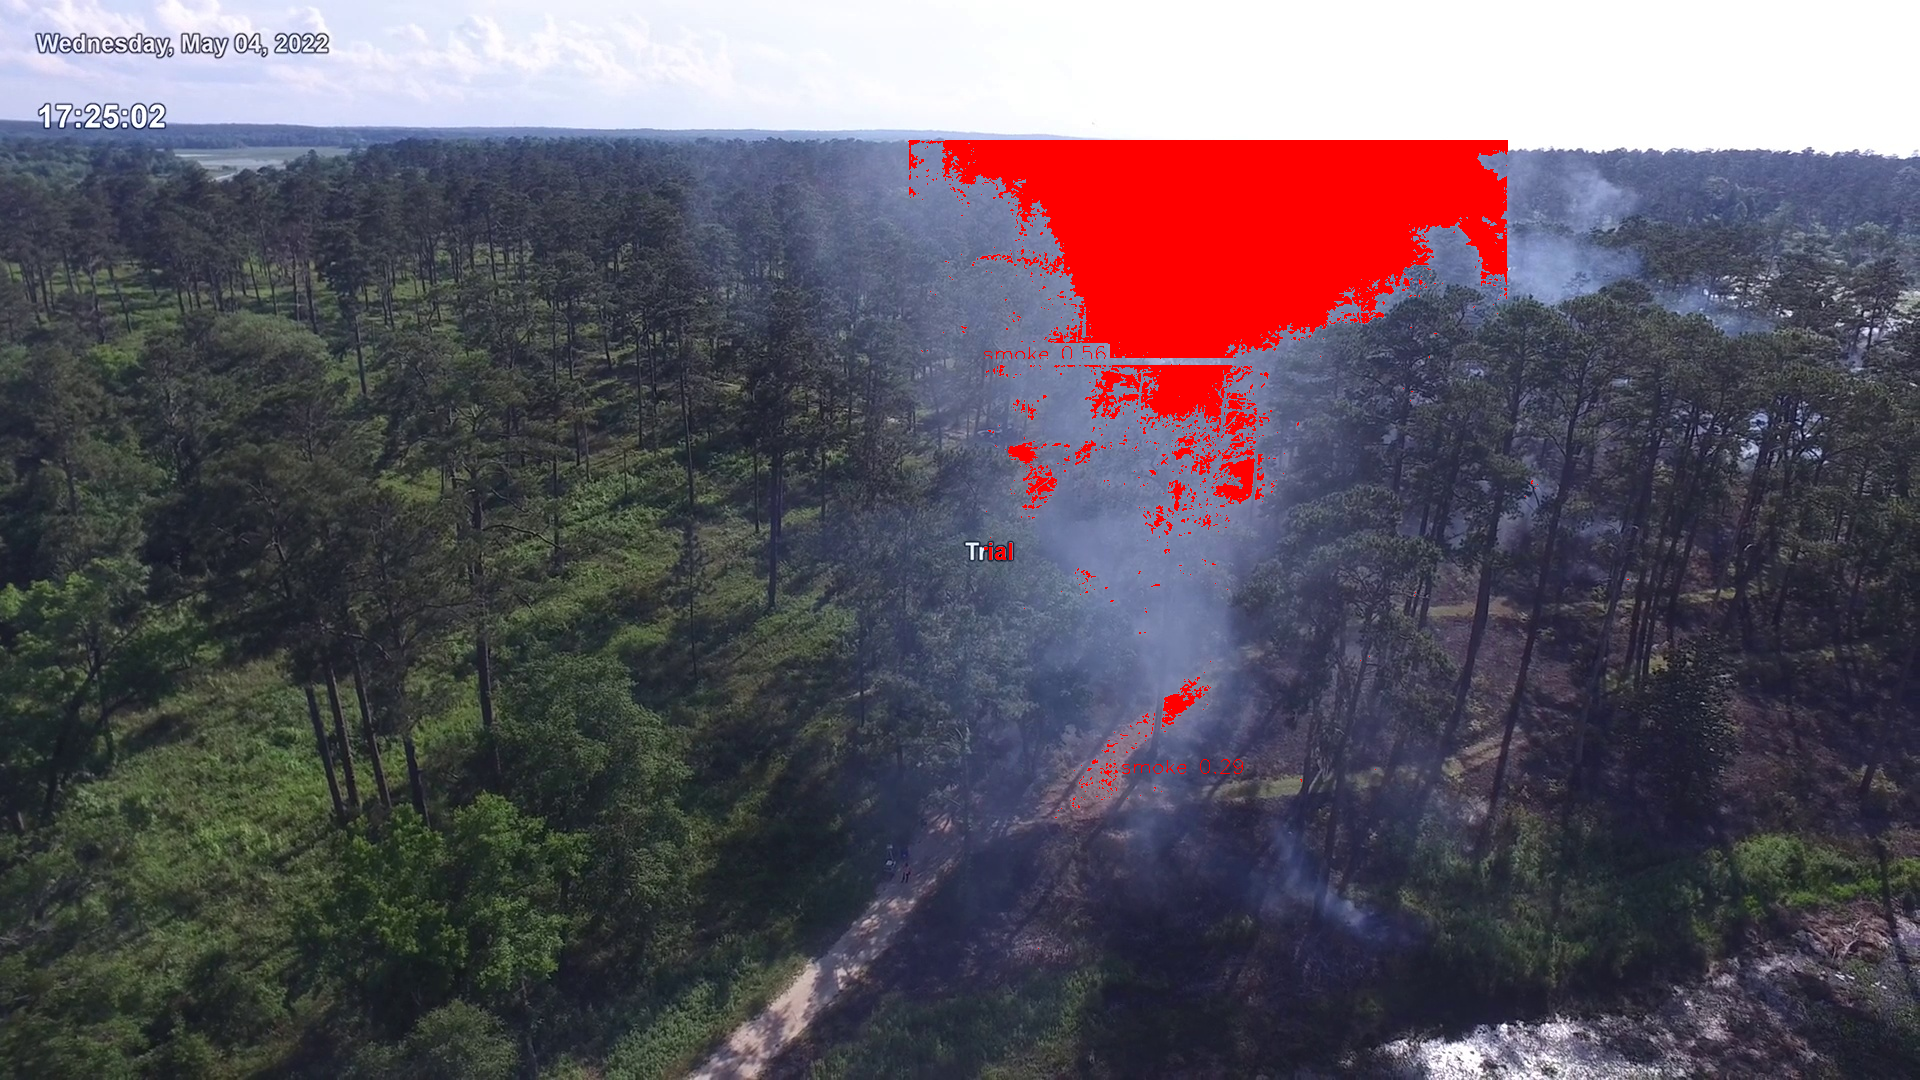

In [ ]:


import pandas as pd
import cv2
import numpy as np
from google.colab import files
from google.colab.patches import cv2_imshow
import os  # For filename processing

# =====================[ CONFIGURABLE PARAMETERS ]=====================
filtered_csv_file = "/content/filtered_pixels_all.csv" # CSV file containing pixel locations
output_image_file = "/content/output_image.jpg"  # Output image path

# ========================[ LOAD FILTERED DATASET ]=============================
try:
    filtered_data = pd.read_csv(filtered_csv_file)
except FileNotFoundError:
    print(f" Error: File '{filtered_csv_file}' not found. Please check the path.")
    exit()

# Ensure required columns exist
required_columns = {"image_name", "x", "y"}
if not required_columns.issubset(filtered_data.columns):
    print(f" Error: CSV file must contain columns {required_columns}. Found: {list(filtered_data.columns)}")
    exit()

# Normalize dataset filenames (strip spaces, convert to lowercase)
filtered_data["image_name"] = filtered_data["image_name"].str.strip().str.lower()

# Fix dataset filenames: Ensure they all end with ".jpg"
filtered_data["image_name"] = filtered_data["image_name"].apply(lambda name: name if name.endswith(".jpg") else name + ".jpg")



# ========================[ UPLOAD IMAGE ]=============================
print("\n Please upload the image you want to process.")
uploaded = files.upload()

# Get the uploaded image filename
uploaded_filename = list(uploaded.keys())[0]  # Example: "masked_frame88.jpg"

# Normalize uploaded filename: Remove extension, remove "masked_" prefix, and convert to lowercase
image_filename = os.path.splitext(uploaded_filename)[0].strip().lower()
image_filename = image_filename.replace("masked_", "") + ".jpg"  # Ensure it has .jpg

print(f"\n Checking for exact match: {image_filename}")

# Read the image
image = cv2.imread(uploaded_filename)
if image is None:
    print(f" Error: Could not read the image '{uploaded_filename}'.")
    exit()

# Get image dimensions
img_height, img_width = image.shape[:2]

# ========================[ MATCH IMAGE IN DATASET ]=============================
image_data = filtered_data[filtered_data["image_name"] == image_filename]

if image_data.empty:
    print(f"\n No pixel data found for '{uploaded_filename}' in the dataset. Exiting.")
    exit()

# ========================[ MARK PIXELS AS RED ]=============================
for _, row in image_data.iterrows():
    x, y = int(row["x"]), int(row["y"])

    # Ensure x, y are within image bounds
    if 0 <= x < img_width and 0 <= y < img_height:
        image[y, x] = [0, 0, 255]  # Mark pixel as red (BGR format in OpenCV)

# ========================[ SAVE & DISPLAY OUTPUT ]=============================
cv2.imwrite(output_image_file, image)
print(f"\n Output image saved as: {output_image_file}")

# Display the modified image
cv2_imshow(image)


##KDE


 Unique image names in dataset (after normalization):
['frame576.jpg' 'frame1463.jpg' 'frame6409.jpg' 'frame1356.jpg'
 'frame3078.jpg' 'frame2971.jpg' 'frame1031.jpg' 'frame6210.jpg'
 'frame2193.jpg' 'frame212.jpg' 'frame6086.jpg' 'frame5919.jpg'
 'frame5978.jpg' 'frame1349.jpg' 'frame1924.jpg' 'frame6298.jpg'
 'frame2185.jpg' 'frame1410.jpg' 'frame528.jpg' 'frame2239.jpg'
 'frame88.jpg' 'frame1640.jpg' 'frame6201.jpg' 'frame5700.jpg'
 'frame2389.jpg' 'frame3151.jpg' 'frame1990.jpg' 'frame592.jpg'
 'frame1387.jpg' 'frame543.jpg']

 Please upload the image you want to process.


Saving frame6086.jpg to frame6086.jpg

 Checking for exact match: frame6086.jpg


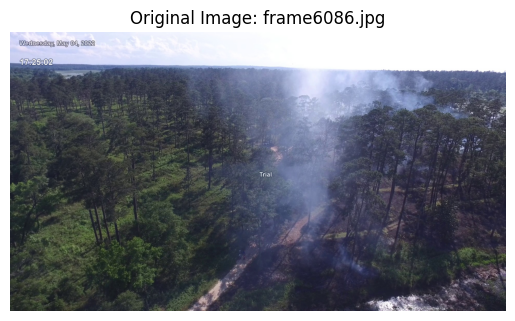

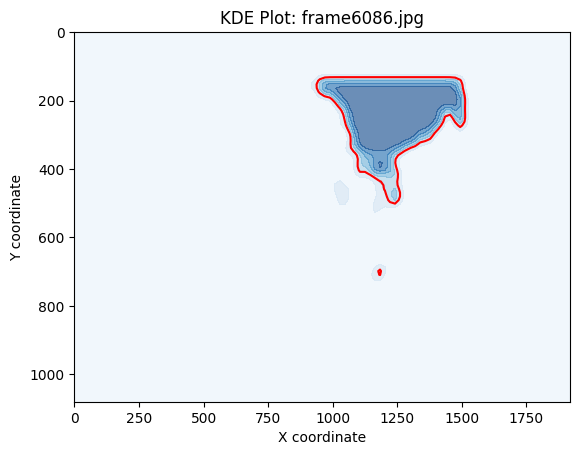

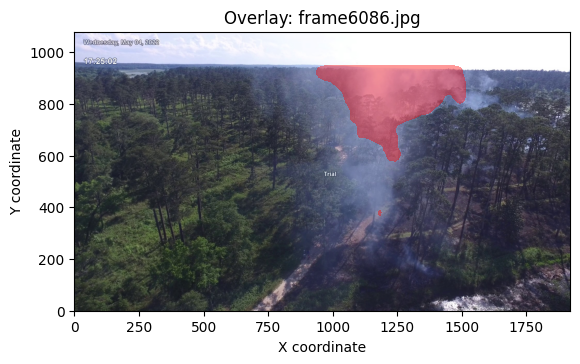


✅ KDE Analysis completed for 'frame6086.jpg'.
Saved output images in: /content/kde_outputs


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.neighbors import KernelDensity
from google.colab import files
from PIL import Image
import os  # For handling filenames

# =====================[ CONFIGURABLE PARAMETERS ]=====================
filtered_csv_file = "/content/filtered_pixels_all.csv"  # CSV file containing pixel locations
output_folder = "/content/kde_outputs"  # Folder to save results
os.makedirs(output_folder, exist_ok=True)  # Create output folder if it doesn't exist

# ========================[ LOAD FILTERED DATASET ]=============================
try:
    df = pd.read_csv(filtered_csv_file)
except FileNotFoundError:
    print(f" Error: File '{filtered_csv_file}' not found. Please check the path.")
    exit()

# Ensure required columns exist
required_columns = {"image_name", "x", "y"}
if not required_columns.issubset(df.columns):
    print(f" Error: CSV file must contain columns {required_columns}. Found: {list(df.columns)}")
    exit()

# Normalize dataset filenames (strip spaces, convert to lowercase)
df["image_name"] = df["image_name"].str.strip().str.lower()

# Print all unique filenames in dataset
print("\n Unique image names in dataset (after normalization):")
print(df["image_name"].unique())

# ========================[ UPLOAD IMAGE ]=============================
print("\n Please upload the image you want to process.")
uploaded = files.upload()

# Get the uploaded image filename
uploaded_filename = list(uploaded.keys())[0]  # Example: "masked_frame88.jpg"

# Normalize uploaded filename: Remove extension, remove "masked_" prefix, and convert to lowercase
image_filename = os.path.splitext(uploaded_filename)[0].strip().lower()
image_filename = image_filename.replace("masked_", "") + ".jpg"  # Ensure it has .jpg

print(f"\n Checking for exact match: {image_filename}")

# Read the image
image = Image.open(uploaded_filename)
image_np = np.array(image)  # Convert image to NumPy array for visualization
img_width, img_height = image.size

# ========================[ MATCH IMAGE IN DATASET ]=============================
image_data = df[df["image_name"] == image_filename]

if image_data.empty:
    print(f"\n No pixel data found for '{uploaded_filename}' in the dataset. Exiting.")
    exit()

# ========================[ KDE DENSITY ANALYSIS ]=============================

# Extract x, y coordinates
X = image_data[['x', 'y']].values

# Define the grid for plotting KDE (matching image resolution)
x_min, x_max = 0, img_width
y_min, y_max = 0, img_height
xgrid, ygrid = np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100)
X_grid, Y_grid = np.meshgrid(xgrid, ygrid)
xy_grid = np.vstack([X_grid.ravel(), Y_grid.ravel()]).T

# Fit 2D KDE
kde = KernelDensity(kernel='gaussian', bandwidth=15).fit(X)
log_dens = kde.score_samples(xy_grid)
dens = np.exp(log_dens).reshape(X_grid.shape)

# Compute the 95% quantile for KDE density
quantile_95 = np.quantile(dens, q=0.95)

# ========================[ PLOT RESULTS ]=============================

# 1. Original Image
fig1, ax1 = plt.subplots()
ax1.imshow(image, cmap='gray')
ax1.set_title(f'Original Image: {image_filename}')
ax1.axis('off')
fig1.savefig(f"{output_folder}/original_{image_filename}.png")

# 2. KDE Plot
fig2, ax2 = plt.subplots()
ax2.set_title(f'KDE Plot: {image_filename}')
ax2.set_xlabel('X coordinate')
ax2.set_ylabel('Y coordinate')
ax2.set_xlim(x_min, x_max)
ax2.set_ylim(y_min, y_max)
ax2.invert_yaxis()  # Invert y-axis to match data orientation

# Draw the filled contour for the KDE
ax2.contourf(X_grid, Y_grid, dens, cmap='Blues', alpha=0.6)
# Draw the contour line for the 95% quantile
ax2.contour(X_grid, Y_grid, dens, levels=[quantile_95], colors='red')
fig2.savefig(f"{output_folder}/kde_{image_filename}.png")

# 3. Overlay: Original Image with Inverted 95% Quantile Contour
fig3, ax3 = plt.subplots()
ax3.imshow(image, cmap='gray', extent=[x_min, x_max, y_min, y_max])
ax3.set_title(f'Overlay: {image_filename}')
ax3.set_xlabel('X coordinate')
ax3.set_ylabel('Y coordinate')
ax3.set_xlim(x_min, x_max)
ax3.set_ylim(y_min, y_max)

# Overlay the filled contour for the 95% quantile, with Y-axis inversion
ax3.contourf(X_grid, Y_grid[::-1], dens, levels=[quantile_95, dens.max()], colors='red', alpha=0.4)
fig3.savefig(f"{output_folder}/overlay_{image_filename}.png")

# ========================[ DISPLAY OUTPUTS ]=============================
plt.show()

print(f"\n KDE Analysis completed for '{image_filename}'.")
print(f"Saved output images in: {output_folder}")


#Section 2 - for User-Provided Combined Masked Image (YOLO+RCNN merged)

## Block 1 — RGB Threshold Filtering and Highlighting


 Please upload your combined masked image (YOLO + RCNN merged).


Saving combined_frame528.jpg to combined_frame528.jpg
Uploaded: combined_frame528.jpg
 Running RGB threshold filtering...
 Filtered pixel data saved: /content/combined_mask_results/filtered_pixels_combined.csv
 Highlighted image saved: /content/combined_mask_results/filtered_highlighted.jpg


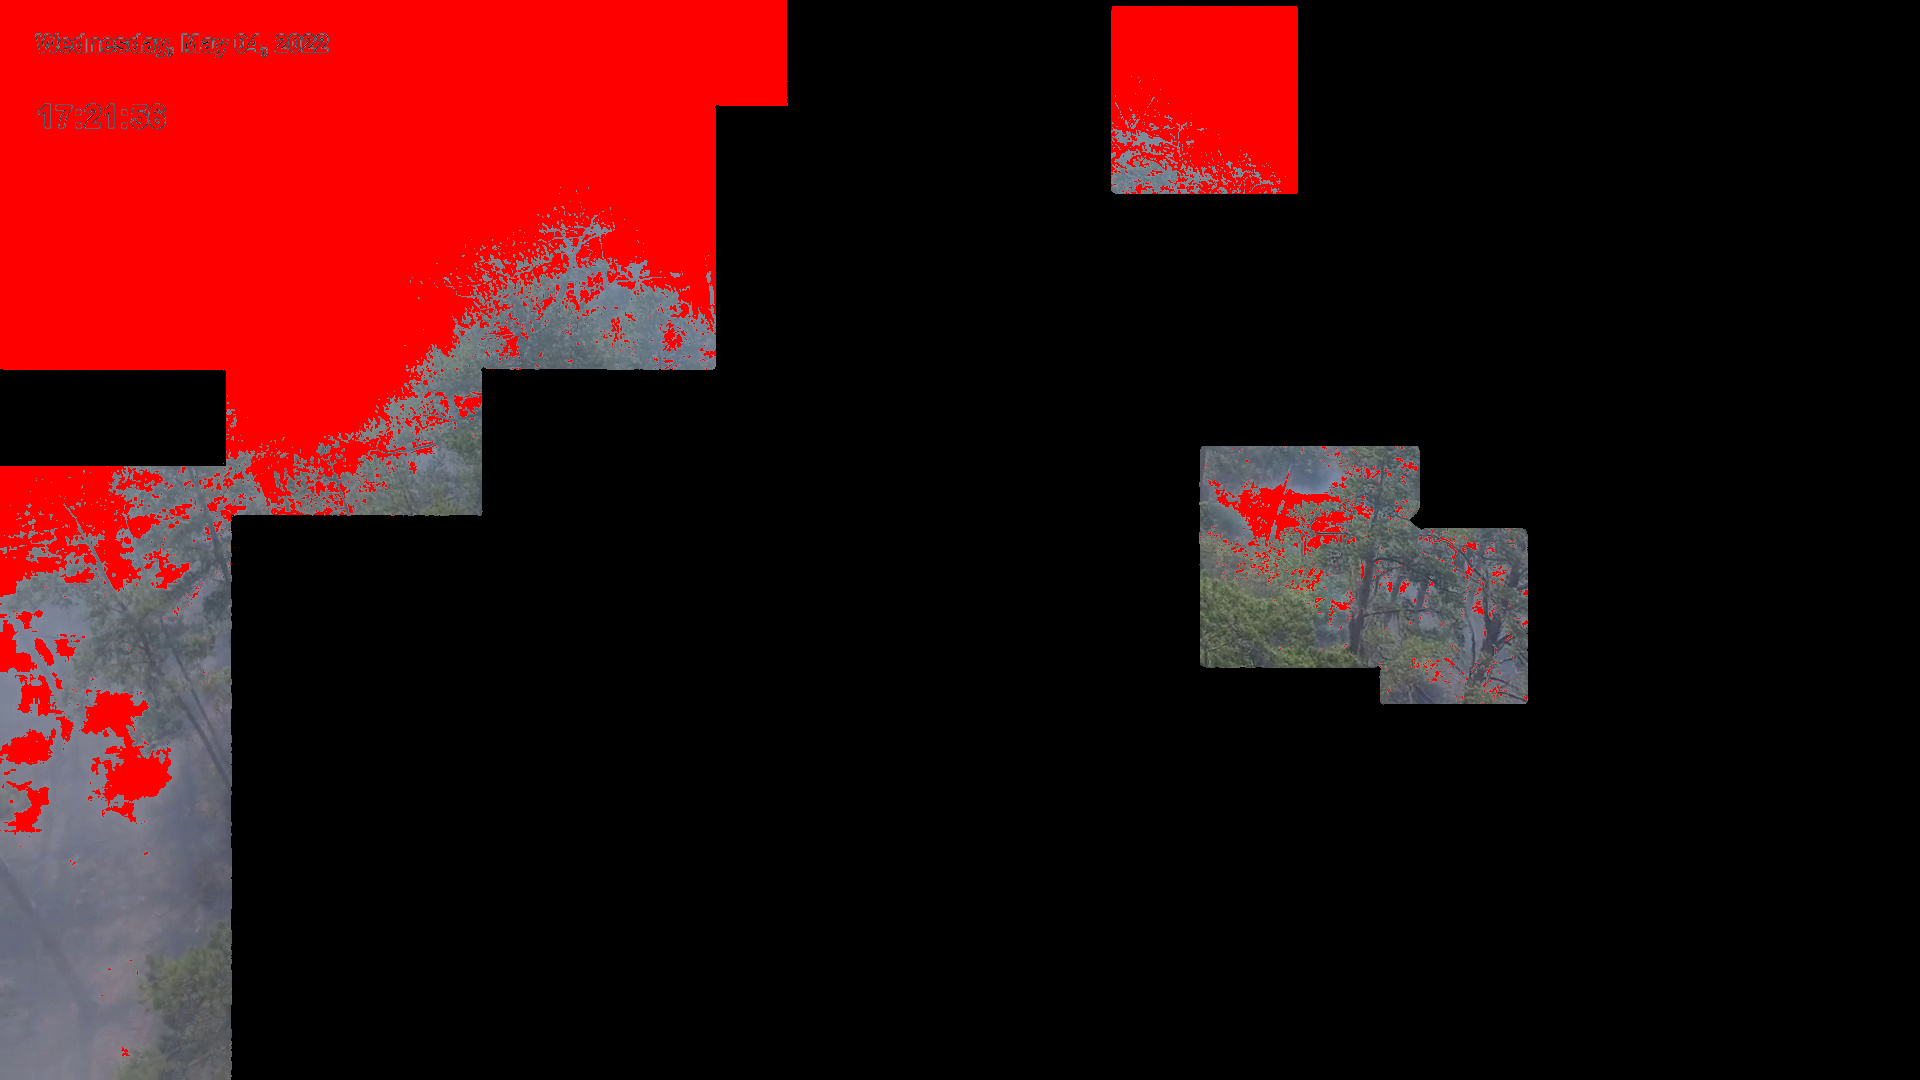

In [1]:

import os
import cv2
import numpy as np
import pandas as pd
from google.colab import files
from google.colab.patches import cv2_imshow

# --------------------- Configuration ---------------------
OUTPUT_DIR = "/content/combined_mask_results"
os.makedirs(OUTPUT_DIR, exist_ok=True)
FILTERED_CSV = os.path.join(OUTPUT_DIR, "filtered_pixels_combined.csv")
FILTERED_IMAGE = os.path.join(OUTPUT_DIR, "filtered_highlighted.jpg")

# RGB threshold range for bright/smoke-like pixels
THRESH_MIN = 130
THRESH_MAX = 255

# --------------------- Upload Image -----------------------
print("\n Please upload your combined masked image (YOLO + RCNN merged).")
uploaded = files.upload()
uploaded_filename = list(uploaded.keys())[0]
print(f"Uploaded: {uploaded_filename}")

# Read image
image_bgr = cv2.imread(uploaded_filename)
if image_bgr is None:
    raise ValueError(f"Could not read image '{uploaded_filename}'.")

image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
h, w = image_rgb.shape[:2]

# --------------------- RGB Filtering ----------------------
print(" Running RGB threshold filtering...")

filtered_pixels = []
mask = np.zeros((h, w), dtype=np.uint8)

for y in range(h):
    for x in range(w):
        R, G, B = image_rgb[y, x]
        if (THRESH_MIN <= R <= THRESH_MAX and
            THRESH_MIN <= G <= THRESH_MAX and
            THRESH_MIN <= B <= THRESH_MAX):
            filtered_pixels.append([x, y, R, G, B])
            mask[y, x] = 255  # white pixel in mask

# Highlight thresholded regions in red
highlighted = image_bgr.copy()
highlighted[mask == 255] = [0, 0, 255]

# Save outputs
if filtered_pixels:
    df = pd.DataFrame(filtered_pixels, columns=["x", "y", "R", "G", "B"])
    df.to_csv(FILTERED_CSV, index=False)
    print(f" Filtered pixel data saved: {FILTERED_CSV}")
else:
    print("⚠️ No bright pixels found in the given range.")
    df = pd.DataFrame(columns=["x", "y", "R", "G", "B"])

cv2.imwrite(FILTERED_IMAGE, highlighted)
print(f" Highlighted image saved: {FILTERED_IMAGE}")

# Display the highlighted image (for Colab)
cv2_imshow(highlighted)


### Block 2 — KDE Density Estimation and Visualization on Original Image

Upload the original image corresponding to the combined masked image.


Saving frame528.jpg to frame528.jpg
Original image uploaded: frame528.jpg
Performing KDE density estimation...


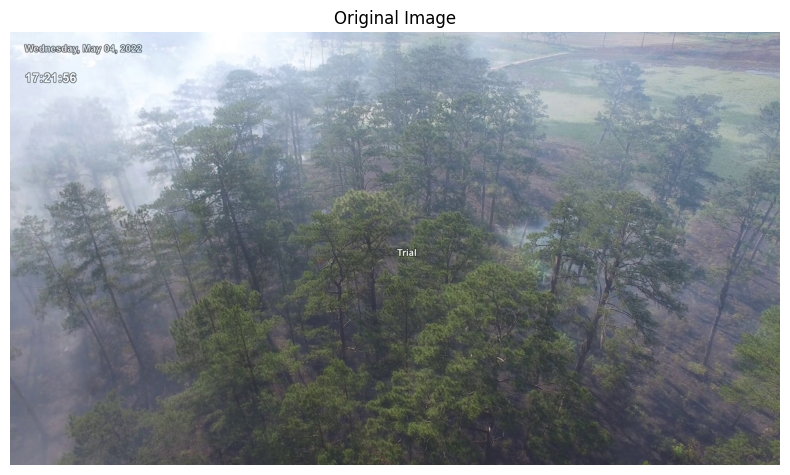

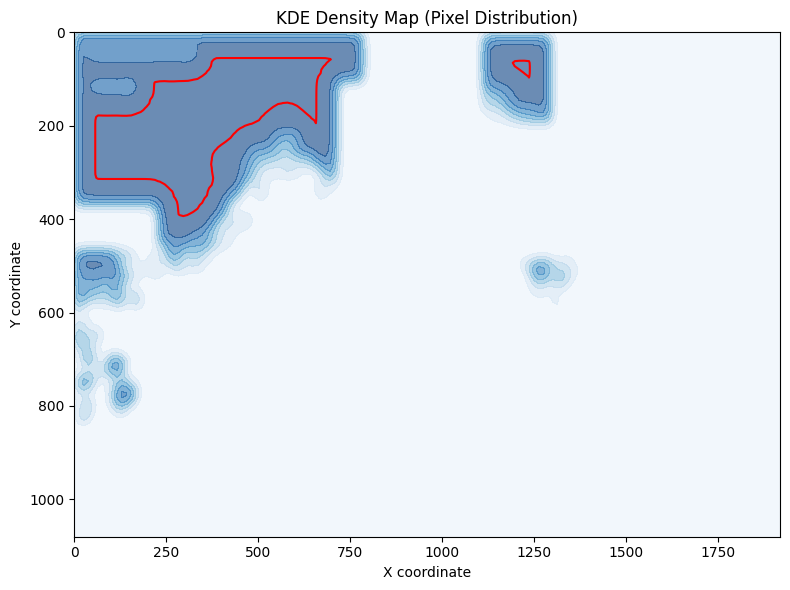

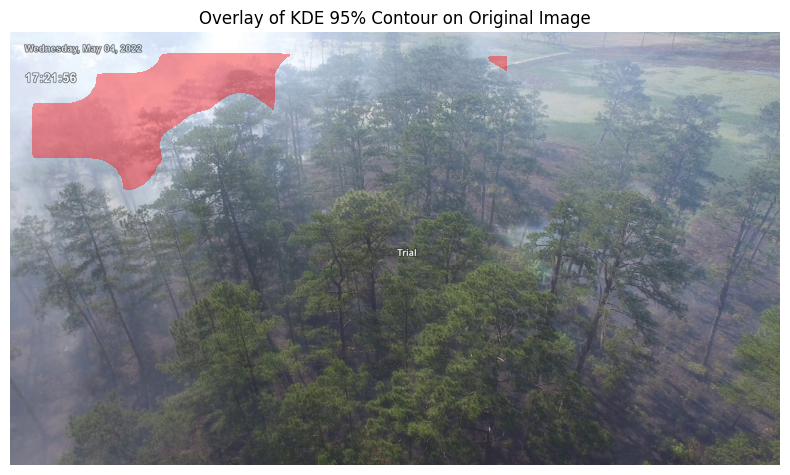

KDE results generated successfully.
KDE heatmap saved to: /content/combined_mask_results/kde_plot.png
Overlay image saved to: /content/combined_mask_results/overlay_plot.png


In [4]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KernelDensity
from google.colab import files
from PIL import Image

# --------------------- Configuration ---------------------
OUTPUT_DIR = "/content/combined_mask_results"
FILTERED_CSV = os.path.join(OUTPUT_DIR, "filtered_pixels_combined.csv")
KDE_PLOT = os.path.join(OUTPUT_DIR, "kde_plot.png")
OVERLAY_PLOT = os.path.join(OUTPUT_DIR, "overlay_plot.png")

# --------------------- Load Filtered Data -----------------
if not os.path.exists(FILTERED_CSV):
    raise FileNotFoundError("Filtered CSV not found. Please run Block 1 first.")

df = pd.read_csv(FILTERED_CSV)
if df.empty:
    raise ValueError("No pixel data found in the filtered CSV. Check the Block 1 output.")

# --------------------- Upload Original Image --------------
print("Upload the original image corresponding to the combined masked image.")
uploaded = files.upload()

if not uploaded:
    raise ValueError("No file uploaded. Please provide the original image.")

orig_filename = list(uploaded.keys())[0]
print(f"Original image uploaded: {orig_filename}")

# Load the original image
orig_image = Image.open(orig_filename).convert("RGB")
orig_np = np.array(orig_image)
img_width, img_height = orig_image.size

# --------------------- KDE Computation --------------------
print("Performing KDE density estimation...")

# Extract pixel coordinates from the CSV
X = df[["x", "y"]].values

# Build the evaluation grid
xgrid = np.linspace(0, img_width, 150)
ygrid = np.linspace(0, img_height, 150)
X_grid, Y_grid = np.meshgrid(xgrid, ygrid)
xy_grid = np.vstack([X_grid.ravel(), Y_grid.ravel()]).T

# Fit the 2-D KDE
kde = KernelDensity(kernel="gaussian", bandwidth=15).fit(X)
log_dens = kde.score_samples(xy_grid)
dens = np.exp(log_dens).reshape(X_grid.shape)

# Compute 95% quantile contour
quantile_95 = np.quantile(dens, 0.95)

# --------------------- Visualization ----------------------

# 1. Original Image
fig0, ax0 = plt.subplots(figsize=(8, 6))
ax0.imshow(orig_np)
ax0.set_title("Original Image")
ax0.axis("off")
fig0.tight_layout()
plt.show()

# 2. KDE Heatmap (on blank background)
fig1, ax1 = plt.subplots(figsize=(8, 6))
ax1.contourf(X_grid, Y_grid, dens, cmap="Blues", alpha=0.6)
ax1.contour(X_grid, Y_grid, dens, levels=[quantile_95], colors="red")
ax1.set_title("KDE Density Map (Pixel Distribution)")
ax1.set_xlabel("X coordinate")
ax1.set_ylabel("Y coordinate")
ax1.invert_yaxis()
fig1.tight_layout()
fig1.savefig(KDE_PLOT, dpi=200, bbox_inches="tight")
plt.show()

# 3. KDE Overlay on the Original Image
fig2, ax2 = plt.subplots(figsize=(8, 6))
ax2.imshow(orig_np, extent=[0, img_width, 0, img_height])
ax2.contourf(
    X_grid,
    Y_grid[::-1],
    dens,
    levels=[quantile_95, dens.max()],
    colors="red",
    alpha=0.4,
)
ax2.set_title("Overlay of KDE 95% Contour on Original Image")
ax2.axis("off")
fig2.tight_layout()
fig2.savefig(OVERLAY_PLOT, dpi=200, bbox_inches="tight")
plt.show()

# --------------------- Completion Message -----------------
print("KDE results generated successfully.")
print(f"KDE heatmap saved to: {KDE_PLOT}")
print(f"Overlay image saved to: {OVERLAY_PLOT}")
